In [1]:
include("../src/JuliaMBD.jl")

Main.JuliaMBD

In [2]:
using DifferentialEquations
using Plots
using .JuliaMBD

  4.917226 seconds (18.16 M allocations: 995.514 MiB, 2.86% gc time, 99.61% compilation time: 10% of which was recompilation)


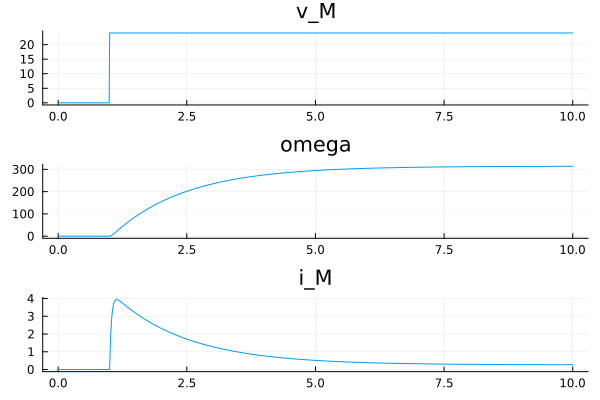

In [3]:
@model DCMotorDisk begin
    ## モータ特性
    @parameter begin
        R = 5.7        # 電気抵抗 [Ω]
        L = 0.2        # インダクタンス [H]
        K_e = 7.16e-2  # 逆起電力定数 [V/(rad/s)]
        K_tau = 7.2e-2 # トルク定数 [N m/A]
        J_M = 0.11e-3  # 慣性モーメント [kg m^2]
    end
        
    ## ディスク特性
    @parameter begin
        J_I = 1.3e-3 # 慣性モーメント [kg m^2]
        D = 6.0e-5   # 粘性減衰係数 [N m /(rad/s)]
    end

    @block begin
        in1 = Inport(:v_M) # 印加電圧 [V]
        out1 = Outport(:omega) # 角速度 [rad/s]
        out2 = Outport(:i_M) # 電流 [A]

        gain = Gain(K=1/L)
        integrator = Integrator() # outport:i_M
        gain1 = Gain(K=K_tau) # outport:tau_M
        gain2 = Gain(K=1/(J_M+J_I))
        integrator1 = Integrator() # outport:omega
        gain3 = Gain(K=D)
        gain4 = Gain(K=K_e)
        gain5 = Gain(K=R)
        add1 = Add(signs=[:+, :-, :-])
        add2 = Add(signs=[:+, :-])
    end

    @connect begin
        in1.out => add1.in1
        gain4.out => add1.in2
        gain5.out => add1.in3
        add1.out => gain.in
        gain.out => integrator.in
        integrator.out => gain1.in
        integrator.out => gain5.in
        integrator.out => out2.in
        gain1.out => add2.in1
        gain3.out => add2.in2
        add2.out => gain2.in
        gain2.out => integrator1.in
        integrator1.out => out1.in
        integrator1.out => gain3.in
        integrator1.out => gain4.in
    end
end

@model TestDCMotorDisk begin
    @parameter begin
        v0::Float64 = 24.0
    end

    @block begin
        motor_and_disk = DCMotorDisk()
        step = Step(steptime = 1, finalvalue = v0)
    end

    @connect step.out => motor_and_disk.v_M

    @scope begin
        motor_and_disk.omega => omega
        motor_and_disk.i_M => i_M
        motor_and_disk.v_M => v_M
    end
end

@time begin
    m = @compile TestDCMotorDisk()
    result = simulate(m, tspan=(0.0, 10.0))
    plot(result)
end

  0.090237 seconds (319.82 k allocations: 16.837 MiB, 91.05% compilation time)


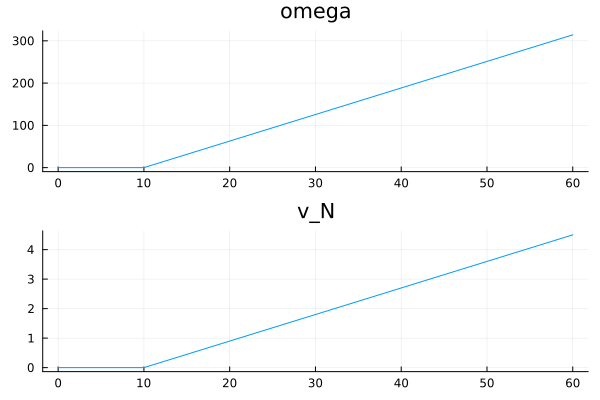

In [4]:
@model Tachogenerator begin
    @parameter begin
        alpha_T = 1.5/1000 # センサ計数 [V/rpm]
    end

    @block begin
        in1 = Inport(:omega) # 角速度 [rad/s]
        out1 = Outport(:v_N) # 出力電圧 [V]
        gain = Gain(K=60/(2*pi)) # outport:N
        gain1 = Gain(K=alpha_T)
    end

    @connect begin
        in1.out => gain.in
        gain.out => gain1.in
        gain1.out => out1.in
    end
end

@model TestTachogenerator begin
    @parameter begin
        omega_d = 2 * pi
    end

    @block begin
        tacho = Tachogenerator()
        ramp = Ramp(starttime = 10, slope = omega_d)
    end
    
    @connect ramp.out => tacho.omega

    @scope begin
        tacho.omega => omega
        tacho.v_N => v_N
    end
end

@time begin
    m = @compile TestTachogenerator()
    result = simulate(m, tspan=(0.0, 60.0))
    plot(result)
end

  0.321572 seconds (1.64 M allocations: 89.897 MiB, 95.69% compilation time)


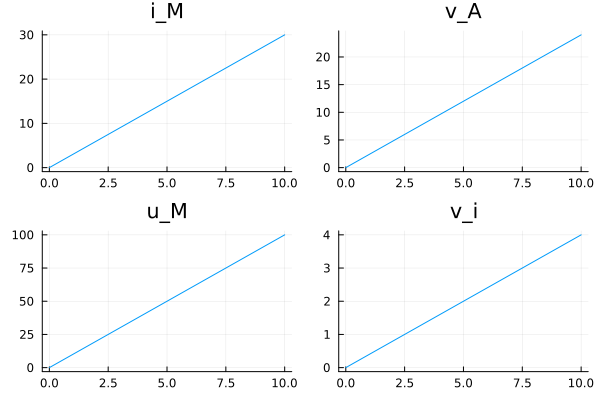

In [5]:
@model MotorDriver begin
    @block begin
        in1 = Inport(:Vs) # 外部電源電圧 [V]
        in2 = Inport(:u_M) # デューティ比 [%]
        out1 = Outport(:v_A) # アンプ出力電圧　[V]
        product = Product()
        gain = Gain(K=1/100)
    end
    
    @connect begin
        in1.out => product.in1
        in2.out => gain.in
        gain.out => product.in2
        product.out => out1.in
    end
end

@model CurrentSensor begin
    @parameter begin
        alpha_i = 5/37.5 # センサ係数 [V/A]
    end
        
    @block begin
        in3 = Inport(:i_M) # 電流 [A](モーターに流れる電流) 
        out2 = Outport(:v_i) # 電流センサ出力電圧 [V]
        gain1 = Gain(K=alpha_i)
    end

    @connect begin
        in3.out => gain1.in
        gain1.out => out2.in
    end
end

@model TestMotorDriver begin
    @parameter begin
        Vs = 24.0 # 電源電圧
        u_M_d = 10
        i_M_d = 3
    end

    @block begin
        constant = Constant(value=Vs)
        ramp = Ramp(slope = u_M_d, starttime = 0, initialoutput = 0)
        ramp1 = Ramp(slope = i_M_d, starttime = 0, initialoutput = 0)
        motordriver = MotorDriver()
        currentsensor = CurrentSensor()
    end

    @connect begin
        constant.out => motordriver.Vs
        ramp.out => motordriver.u_M
        ramp1.out => currentsensor.i_M
    end
    
    @scope begin
        currentsensor.i_M => i_M
        currentsensor.v_i => v_i
        motordriver.u_M => u_M
        motordriver.v_A => v_A
    end    
end

@time begin
    m = @compile TestMotorDriver()
    results = simulate(m, tspan=(0.0, 10.0))
    plot(results, layout=(2,2))
end

  1.588631 seconds (6.49 M allocations: 363.767 MiB, 3.29% gc time, 98.75% compilation time)


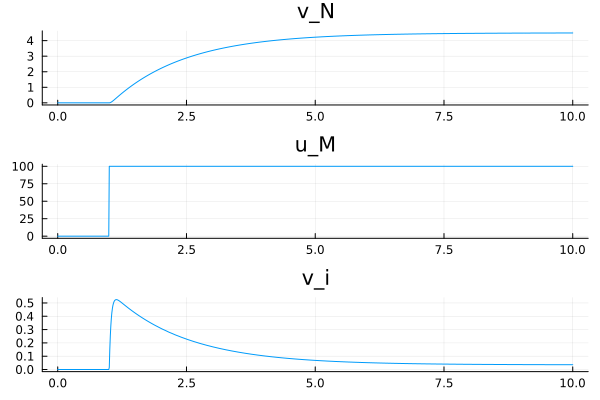

In [6]:
@model PlantModel begin
    @parameter begin
        Vs = 24.0 # 電源電圧
    end
        
    @block begin
        in1 = Inport(:u_M) # duty比 [%]
        out1 = Outport(:v_N) # 回転数に対する出力電圧 [V]
        out2 = Outport(:v_i) # モーターに流れる電流に対するセンサー電圧 [V]
        constant = Constant(value=Vs)
        motordriver = MotorDriver()
        currentsensor = CurrentSensor()
        motor_and_disk = DCMotorDisk()
        tachogenerator = Tachogenerator()
    end
    
    # @scope begin
    #     motor_and_disk.omega
    #     motor_and_disk.i_M
    #     motordriver.v_A
    # end

    @connect begin
        constant.out => motordriver.Vs
        in1.out => motordriver.u_M
        motordriver.v_A => motor_and_disk.v_M
        currentsensor.v_i => out2.in
        motor_and_disk.omega => tachogenerator.omega
        motor_and_disk.i_M => currentsensor.i_M
        tachogenerator.v_N => out1.in
    end
end

@model TestPlantModel begin
    @parameter begin
        u_M = 100
    end

    @block begin
        step = Step(steptime = 1, finalvalue = :u_M)
        plantmodel = PlantModel()
    end
    
    @connect step.out => plantmodel.u_M

    @scope begin
        plantmodel.v_N => v_N
        plantmodel.v_i => v_i
        plantmodel.u_M => u_M
    end
end

@time begin
    m = @compile TestPlantModel()
    results = simulate(m, tspan=(0.0, 10.0))
    plot(results)
end

  0.422536 seconds (2.08 M allocations: 115.057 MiB, 97.49% compilation time)


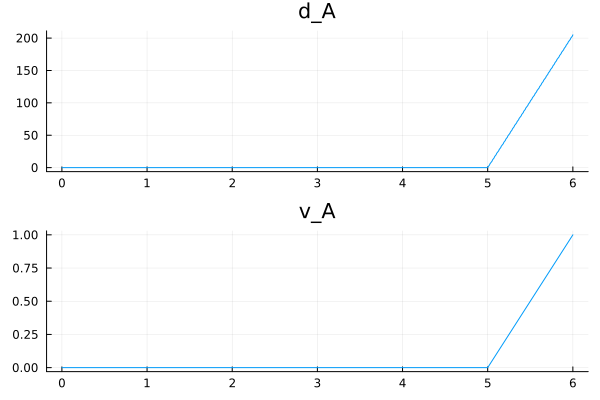

In [7]:
@model ADConverter begin
    @parameter begin
        V_A_min = 0 # 入力電圧（最小） [V]
        V_A_max = 5 # 入力電圧（最大） [V]
        n = 10 # 分解能 [bit]
    end

    @block begin
        in1 = Inport(:v_A) # 入力信号 [V]
        out1 = Outport(:d_A) # デジタル信号
        saturation = Saturation(upperlimit=V_A_max, lowerlimit=V_A_min)
        constant = Constant(value=V_A_min)
        sum1 = Add(signs=[:+, :-])
        gain = Gain(K=((2^n-1)/(V_A_max - V_A_min)))
        quantizer = Quantizer(quantizationinterval = 1)
    end

    @connect begin
        in1.out => saturation.in
        saturation.out => sum1.in1
        constant.out => sum1.in2
        sum1.out => gain.in
        gain.out => quantizer.in
        quantizer.out => out1.in
    end
end

@model TestADConverter begin
    @parameter begin
        v_A_d = 1
    end

    @block begin
        ramp = Ramp(slope = v_A_d, starttime = 5, initialoutput = 0)
        adconverter = ADConverter()
    end
    
    @connect ramp.out => adconverter.v_A

    @scope begin
        adconverter.v_A => v_A
        adconverter.d_A => d_A
    end
end

@time begin
    m = @compile TestADConverter()
    results = simulate(m, tspan=(0.0, 6.0))
    plot(results)
end

  0.180364 seconds (363.85 k allocations: 20.350 MiB, 92.84% compilation time)


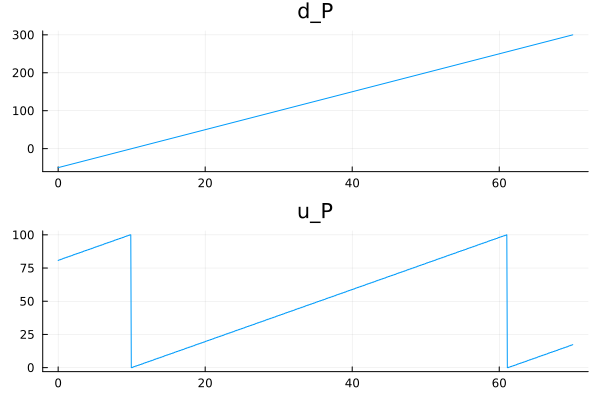

In [9]:
@model PulseGenerator begin
    @parameter begin
        m = 8 # 分解能 [bit]
    end

    @block begin
        in1 = Inport(:d_P) # 入力デジタル信号
        out1 = Outport(:u_P) # duty比 [%]
        quantizer = Quantizer(quantizationinterval = 1)
        constant = Constant(value = 2^m)
        # math = Mod(in1=InPort(Int), in2=InPort(Int))
        math = Mod()
        gain = Gain(K=100/(2^m-1))
    end

    @connect begin
        in1.out => quantizer.in
        quantizer.out => math.in1
        constant.out => math.in2
        math.out => gain.in
        gain.out => out1.in
    end
end

@model TestPulseGenerator begin
    @parameter begin
        d_P_d = 5
    end

    @block begin
        ramp = Ramp(slope = d_P_d, starttime = 0, initialoutput = -50)
        pulsegenerator = PulseGenerator()
    end
    
    @scope begin
        pulsegenerator.u_P => u_P
        pulsegenerator.d_P => d_P
    end
    
    @connect ramp.out => pulsegenerator.d_P
end

@time begin
    m = @compile TestPulseGenerator()
    results = simulate(m, tspan=(0.0, 70.0))
    plot(results)
end


  0.325680 seconds (821.18 k allocations: 44.787 MiB, 92.92% compilation time)


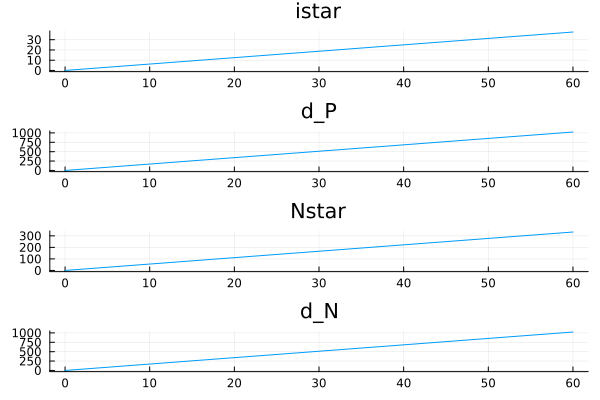

In [11]:
@model Decoder begin
    @parameter begin
        V_A_min = 0 # 入力電圧（最小） [V]
        V_A_max = 5 # 入力電圧（最大） [V]
        n = 10 # 分解能
        alpha_T = 1.5/100 # センサ係数
        alpha_i = 5/37.5 # センサ係数
    end

    @block begin
        in1 = Inport(:d_N) # 入力デジタル信号
        out1 = Outport(:Nstar) # 計測回転数 [rpm]
        gain = Gain(K=1/alpha_T)
        gain2 = Gain(K=(V_A_max-V_A_min)/(2^n-1))
        constant = Constant(value=V_A_min)
        sum1 = Add(signs=[:+, :+])
    end

    @connect begin
        in1.out => gain2.in
        gain2.out => sum1.in1
        constant.out => sum1.in2
        sum1.out => gain.in
        gain.out => out1.in
    end

    @block begin
        in2 = Inport(:d_P) # 入力デジタル信号
        out2 = Outport(:istar) # 計測電流 [A]
        gain1 = Gain(K=1/alpha_i)
        gain3 = Gain(K=(V_A_max-V_A_min)/(2^n-1))
        constant = Constant(value=V_A_min)
        sum2 = Add(signs=[:+, :+])
    end

    @connect begin
        in2.out => gain3.in
        gain3.out => sum2.in1
        constant.out => sum2.in2
        sum2.out => gain1.in
        gain1.out => out2.in
    end
end

@model TestDecoder begin
    @parameter begin
        n = 10
        d_N_d = (2^n-1)/60
        d_i_d = (2^n-1)/60
    end

    @block begin
        ramp = Ramp(slope = d_N_d, starttime = 0, initialoutput = 0)
        ramp1 = Ramp(slope = d_i_d, starttime = 0, initialoutput = 0)
        decoder = Decoder()
    end
    
    @scope begin
        decoder.Nstar => Nstar
        decoder.istar => istar
        decoder.d_N => d_N
        decoder.d_P => d_P
    end

    @connect begin
        ramp.out => decoder.d_N
        ramp1.out => decoder.d_P
    end
end

@time begin
    m = @compile TestDecoder()
    results = simulate(m, tspan=(0.0, 60.0))
    plot(results)
end

  0.155136 seconds (404.89 k allocations: 21.221 MiB, 92.80% compilation time)


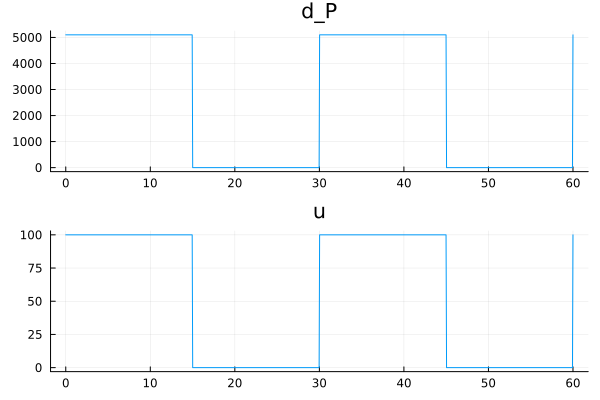

In [14]:
@model Encoder begin
    @parameter begin
        u_min = 0 # 制御出力（最小） [V]
        u_max = 5 # 制御出力（最大） [V]
        m = 8 # 分解能
     end

    @block begin
        in1 = Inport(:u) # 制御出力
        out1 = Outport(:d_P) # デジタル制御出力
        gain = Gain(K=((2^m-1)/(u_max-u_min)))
        constant = Constant(value=u_min)
        sum1 = Add(signs=[:+, :+])
    end
    
    @connect begin
        in1.out => sum1.in1
        constant.out => sum1.in2
        sum1.out => gain.in
        gain.out => out1.in
    end
end

@model TestEncoder begin
    @block begin
        plusgenerator = JuliaMBD.PulseGenerator(amplitude=100, period=30, pulsewidth=50, phasedelay=0) # 名前被り
        encoder = Encoder()
    end
    
    @scope begin
        encoder.u => u
        encoder.d_P => d_P
    end
    
    @connect plusgenerator.out => encoder.u
end

@time begin
    m = @compile TestEncoder()
    results = simulate(m, tspan=(0.0, 60.0))
    plot(results)
end

  0.348088 seconds (755.96 k allocations: 41.585 MiB, 91.16% compilation time)


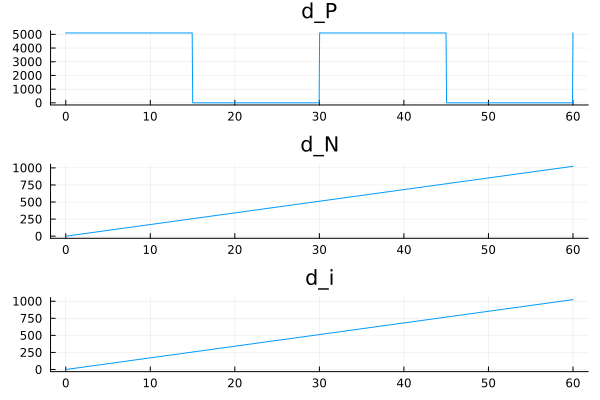

In [16]:
@model Controller begin
    @block begin
        in1 = Inport(:d_N) # 回転数に対するデジタル値
        in2 = Inport(:d_i) # モータ電流に対するデジタル値
        out1 = Outport(:d_P) # デジタルduty比
        decoder = Decoder()
        encoder = Encoder()
        plusgenerator = JuliaMBD.PulseGenerator(amplitude=100, period=30, pulsewidth=50, phasedelay=0)
    end

    @connect begin
        in1.out => decoder.d_N
        in2.out => decoder.d_P
        plusgenerator.out => encoder.u
        encoder.d_P => out1.in
    end
end

@model TestController begin
    @parameter begin
        n = 10
        d_N_d = ((2^n-1)/60)
        d_i_d = ((2^n-1)/60)
    end

    @block begin
        controller = Controller()
        ramp = Ramp(slope = d_N_d, starttime = 0, initialoutput = 0)
        ramp1 = Ramp(slope = d_i_d, starttime = 0, initialoutput = 0)
    end
    
    @scope begin
        controller.d_N => d_N
        controller.d_i => d_i
        controller.d_P => d_P
    end

    @connect begin
        ramp.out => controller.d_N
        ramp1.out => controller.d_i
    end
end

@time begin
    m = @compile TestController()
    results = simulate(m, tspan=(0.0, 60.0))
    plot(results)
end

  0.306561 seconds (799.32 k allocations: 44.798 MiB, 90.44% compilation time)


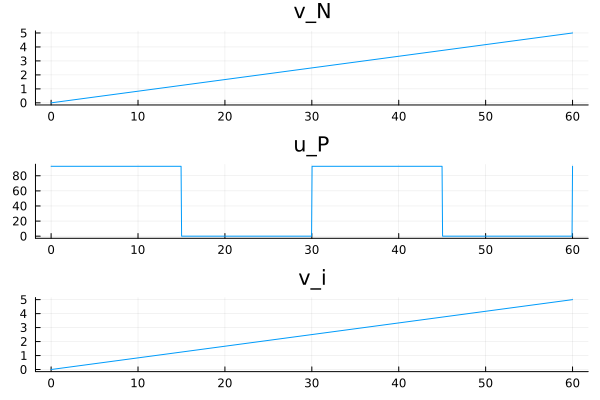

In [19]:
@model ControllerModel begin
    # @parameter begin
    #     Vs = 24.0 # 電源電圧
    # end
        
    @block begin
        in1 = Inport(:v_N) # 回転数に対する出力電圧 [V]
        in2 = Inport(:v_i) # モーターに流れる電流に対するセンサー電圧 [V]
        out1 = Outport(:u_P) # duty比 [%]
        adconverter = ADConverter()
        adconverter1 = ADConverter()
        controller = Controller()
        pulsegenerator = PulseGenerator()
    end
    
    # @scope begin
    #     motor_and_disk.omega
    #     motor_and_disk.i_M
    #     motordriver.v_A
    # end

    @connect begin
        in1.out => adconverter.v_A
        adconverter.d_A => controller.d_N
        in2.out => adconverter1.v_A
        adconverter.d_A => controller.d_i
        controller.d_P => pulsegenerator.d_P
        pulsegenerator.u_P => out1.in
    end
end

@model TestControllerModel begin
    @parameter begin
        v_N_d = 5/60
        v_i_d = 5/60
    end

    @block begin
        controllermodel = ControllerModel()
        ramp = Ramp(slope = v_N_d, starttime = 0, initialoutput = 0)
        ramp1 = Ramp(slope = v_i_d, starttime = 0, initialoutput = 0)
    end
    
    @scope begin
        controllermodel.v_N => v_N
        controllermodel.v_i => v_i
        controllermodel.u_P => u_P
    end

    @connect begin
        ramp.out => controllermodel.v_N
        ramp1.out => controllermodel.v_i
    end
end

@time begin
    m = @compile TestControllerModel()
    results = simulate(m, tspan=(0.0, 60.0))
    plot(results)
end

  1.111277 seconds (3.58 M allocations: 204.081 MiB, 15.02% gc time, 97.09% compilation time)


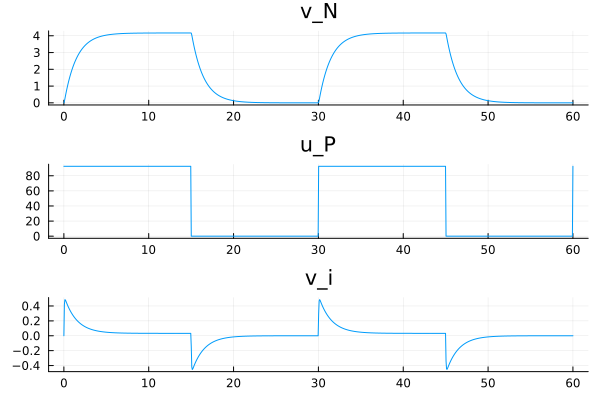

In [21]:
@model SystemModel begin
    @block begin
        # in1 = InBlock(:d_N) # 回転数に対するデジタル値
        # in2 = InBlock(:d_i) # モータ電流に対するデジタル値
        # out1 = OutBlock(:d_P) # デジタルduty比
        decoder = Decoder()
        encoder = Encoder()
        tmppulsegenerator = JuliaMBD.PulseGenerator(amplitude=100, period=30, pulsewidth=50, phasedelay=0)
        adconverter = ADConverter()
        adconverter1 = ADConverter()
        pulsegenerator = PulseGenerator()
        plantmodel = PlantModel()
    end
    
    @scope begin
        plantmodel.v_N => v_N
        plantmodel.v_i => v_i
        pulsegenerator.u_P => u_P
    end

    @connect begin
        adconverter.d_A => decoder.d_N
        adconverter1.d_A => decoder.d_P
        tmppulsegenerator.out => encoder.u
        encoder.d_P => pulsegenerator.d_P
        pulsegenerator.u_P => plantmodel.u_M
        plantmodel.v_N => adconverter.v_A
        plantmodel.v_i => adconverter1.v_A
    end
end

@time begin
    m = @compile SystemModel()
    results = simulate(m, tspan=(0.0, 60.0))
    plot(results)
end
